# Estimación de la supervivencia de los pasajeros del Titanic

In [1]:
%pylab
%matplotlib inline

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


Utilizando los datos del archivo “titanic.csv”, que contienen información del pasaje del Titanic, para la creación de un modelo que pueda predecir si un pasajero sobrevive al hundimiento del barco en el momento de embarque. Para esto se han de seleccionar la variables con mayor capacidad de predicción.
    
# Importación de los datos

In [2]:
import pandas as pd

titanic = pd.read_csv('titanic.csv', sep = ',')
titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [3]:
# Separación de la variable objetivo y las explicativas
target = 'survived'
features = list(titanic.columns)
features.remove('survived')

El objetivo es predecir si el pasajero sobrevive al viaje en el momento de embarcar, por lo que hemos de eliminar las variables `boat` y `body`. Estas solamente estarán disponibles después del siniestro.

In [4]:
# Eliminación de las variables no permitidas
features.remove('boat')
features.remove('body')

En los datos hay registros nulos, para facilitar el análisis los vamos a eliminar los que aparecen en las variables `age` y `fare`.

In [5]:
# Eliminación de los NaN
mask = titanic[['age', 'fare']].applymap(lambda x: math.isnan(x))
titanic = titanic[-mask.any(axis = 1)]

Finalmente, el listado de variables disponibles para el modelo es:

In [6]:
for var in features:
    print(var , ':' , len(set(titanic[var])))

pclass : 3
name : 1043
sex : 2
age : 97
sibsp : 7
parch : 7
ticket : 731
fare : 256
cabin : 175
embarked : 4
home.dest : 349


Podemos representar las variables numéricas

/Users/daniel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


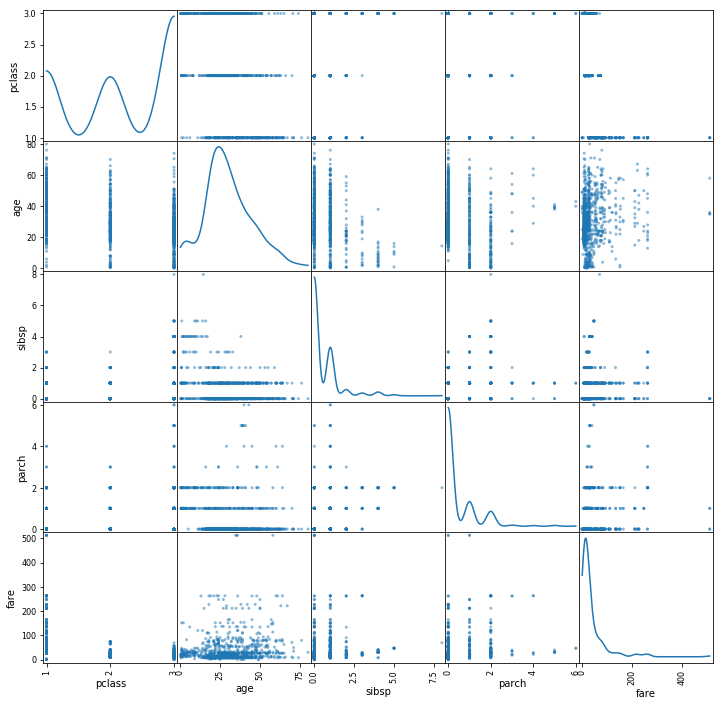

In [7]:
from pandas.tools.plotting import scatter_matrix

scatter_matrix(titanic[features], figsize = (12, 12), diagonal = 'kde');

## ~ Eliminación de las variables que son identificadores
Las variables `name` y `ticket` son identificadores de los pasajeros, por lo que  que no se pueden incluir en el modelo.

Por otro lado, la variable destino (`home.dest`) tienen demasiados niveles y se puede considerar como una variable casi identificadora, por lo que se puede eliminar del modelo. 

In [8]:
features.remove('name')
features.remove('ticket')
features.remove('home.dest')

## ~ Análisis de las variables discretas
En las variables discretas se ha de realizar un análisis para seleccionar las que tienen mayor capacidad predictiva.

In [9]:
titanic[features].head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked
0,1,female,29.00,0,0,211.3375,B5,S
1,1,male,0.92,1,2,151.5500,C22 C26,S
2,1,female,2.00,1,2,151.5500,C22 C26,S
3,1,male,30.00,1,2,151.5500,C22 C26,S
4,1,female,25.00,1,2,151.5500,C22 C26,S


En la tabla se puede ver que las variables discretas que quedan son:
* pclass
* sex
* sibsp
* parch
* cabin
* embarked

Para estas variables se puede obtener la tabla de frecuencias de cada una de ella para ver la posibilidad de que sean incluidas en el modelo y si pueden presentar problemas. 

In [10]:
for var in ['pclass', 'sex', 'sibsp', 'parch', 'cabin', 'embarked']:
    print("Tabla de frecuencias para:", var)
    print(pd.crosstab(titanic[target], titanic[var]))
    print()

Tabla de frecuencias para: pclass
pclass      1    2    3
survived               
0         103  146  369
1         181  115  131

Tabla de frecuencias para: sex
sex       female  male
survived              
0             96   522
1            292   135

Tabla de frecuencias para: sibsp
sibsp       0    1   2   3   4  5  8
survived                            
0         429  133  20  10  19  6  1
1         255  147  16   6   3  0  0

Tabla de frecuencias para: parch
parch       0   1   2  3  4  5  6
survived                         
0         497  65  42  3  4  5  2
1         270  95  55  5  1  1  0

Tabla de frecuencias para: cabin
cabin     A10  A11  A16  A18  A20  A21  A23  A24  A26  A29 ...  E8  F  F E57  \
survived                                                   ...                 
0           1    0    0    1    0    1    0    1    0    1 ...   0  1      0   
1           0    1    1    0    1    0    1    0    1    0 ...   2  0      1   

cabin     F G63  F G73  F2  F33  F4  G6

### Variable: Cabin

En primer lugar, se observa que `cabin`, con 174 niveles, es una variable que no puede ser utilizada para modelar ya que la mayoría de sus niveles solamente tienen un registro.

In [11]:
features.remove('cabin')

En las variables `sibsp` y `parch` han de ser hay niveles que tienen pocos registros significativos. En ambos casos los se ha de realizar una nueva agrupación de niveles con el WoE

In [3]:
def get_WoE(data, var, target):
    crosstab = pd.crosstab(data[target], data[var])
    
    print("Obteniendo el Woe para la variable", var, ":")
    
    for col in crosstab.columns:
        if crosstab[col][1] == 0:
            print("  El WoE para", col, "[", sum(crosstab[col]), "] es infinito")
        else:
            print("  El WoE para", col, "[", sum(crosstab[col]), "] es", np.log(float(crosstab[col][0]) / float(crosstab[col][1])))

### ~ Variable: `sibsp`

In [2]:
get_WoE(titanic, 'sibsp', target)

NameError: name 'titanic' is not defined

In [14]:
titanic.loc[:, 'sibsp_grp'] = None

for row in titanic.index:
    if titanic.loc[row, 'sibsp'] in (0, 2, 3, 4, 5, 8):
        titanic.loc[row, 'sibsp_grp'] = 'n0'
    elif titanic.loc[row, 'sibsp'] == 1:
        titanic.loc[row, 'sibsp_grp'] = 'n1'

get_WoE(titanic, 'sibsp_grp', target)

Obteniendo el Woe para la variable sibsp_grp :
  El WoE para n0 [ 765 ] es 0.549359287768
  El WoE para n1 [ 280 ] es -0.100083458557


#### ~ Variable: `parch`

In [15]:
get_WoE(titanic, 'parch', target)

Obteniendo el Woe para la variable parch :
  El WoE para 0 [ 767 ] es 0.610168067098
  El WoE para 1 [ 160 ] es -0.379489621705
  El WoE para 2 [ 97 ] es -0.269663566949
  El WoE para 3 [ 8 ] es -0.510825623766
  El WoE para 4 [ 5 ] es 1.38629436112
  El WoE para 5 [ 6 ] es 1.60943791243
  El WoE para 6 [ 2 ] es infinito


In [16]:
titanic.loc[:, 'parch_grp'] = None

for row in titanic.index:
    if titanic.loc[row, 'parch'] in (0, 4, 5, 6):
        titanic.loc[row, 'parch_grp'] = 'n0'
    elif titanic.loc[row, 'parch'] in (1, 2, 3):
        titanic.loc[row, 'parch_grp'] = 'n1'

get_WoE(titanic, 'parch_grp', target)

Obteniendo el Woe para la variable parch_grp :
  El WoE para n0 [ 780 ] es 0.624679381282
  El WoE para n1 [ 265 ] es -0.342944751127


## ~ Variables transformadas
Una vez realizada la transformación de las variables se debe eliminar las antiguas y agregar las nuevas del listado de variables.

In [17]:
features.remove('sibsp')
features.remove('parch')

features.append('sibsp_grp')
features.append('parch_grp')

# Listado de variables disponibles para hacer un modelo.
for var in features:
    print(var)

pclass
sex
age
fare
embarked
sibsp_grp
parch_grp


## ~ Análisis de las variables continuas
Las variables continuas que quedan son `age` y `fare`.

### ~ Variable: `age`
Se pueden analizar los histogramas para conocer si existen diferentes comportamientos según la edad.

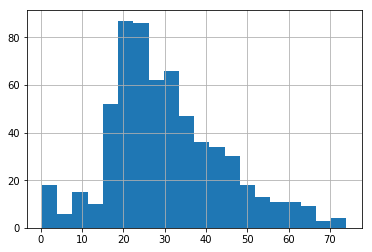

In [18]:
titanic['age'][titanic['survived']==0].hist(bins=20)

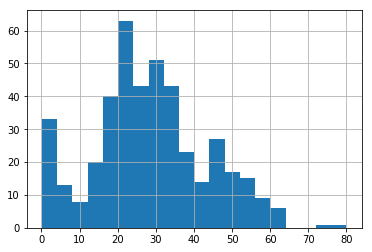

In [19]:
titanic['age'][titanic['survived']==1].hist(bins=20)

Al comparar los histogramas de los que han sobrevivido por edades se puede ver que la supervivencia aumenta por debajo de los 20 años y vuelve aumentar en torno a los 30 y los 45 años. Esto se puede utilizar para realizar una categorización de las variables.

In [20]:
titanic.loc[:, 'age_grp'] = titanic['age'].map(lambda x: 'n0' if x < 9 else 'n1' if x < 31 else 'n2' if x < 56 else 'n3')
get_WoE(titanic, 'age_grp', target) 

Obteniendo el Woe para la variable age_grp :
  El WoE para n0 [ 72 ] es -0.570544858468
  El WoE para n1 [ 539 ] es 0.511815232951
  El WoE para n2 [ 377 ] es 0.304723538307
  El WoE para n3 [ 57 ] es 0.69314718056


##### Variable: `fare`
Se pueden analizar los histogramas para conocer si existen diferentes comportamientos según la tarifa.

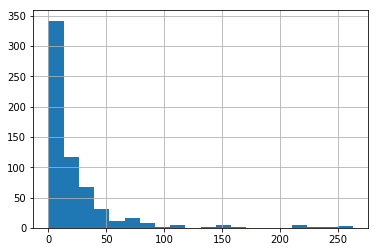

In [21]:
titanic['fare'][titanic['survived']==0].hist(bins=20)

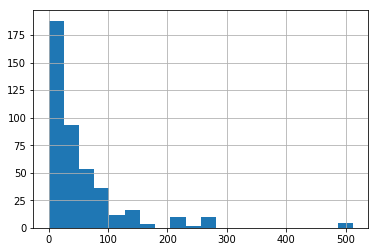

In [22]:
titanic['fare'][titanic['survived']==1].hist(bins=20)

Al comparar los histogramas se puede ver que las tarifas más altas tienen una mayor probabilidad de sobrevivir. De hecho por encima de 300 sobreviven todos.

In [23]:
titanic.loc[:, 'fare_grp'] = titanic['fare'].map(lambda x: 'n0' if x < 25 else 'n1' if x < 90 else 'n2')
get_WoE(titanic, 'fare_grp', target) 

Obteniendo el Woe para la variable fare_grp :
  El WoE para n0 [ 614 ] es 0.817997383439
  El WoE para n1 [ 341 ] es -0.0410614867978
  El WoE para n2 [ 90 ] es -0.955511445027


#### Variables transformadas
Una vez realizada la transformación de las variables se debe eliminar las antiguas y agregar las nuevas del listado de variables.

In [24]:
features.remove('age')
features.remove('fare')

features.append('age_grp')
features.append('fare_grp')

# Listado de variables disponibles para hacer un modelo.
for var in features:
    print(var)

pclass
sex
embarked
sibsp_grp
parch_grp
age_grp
fare_grp


### Creación de un modelo
Una vez transformadas las variables se puede proceder a la creación de un modelo. Para ello primero se han de crear las variables dummies, eliminar las variables colineales y separar los datos en una muestra de entrenamiento y otra de validación.

#### Creación de variables dummies

In [25]:
data_model = pd.concat((pd.get_dummies(titanic['pclass'], prefix = 'pclass'),
                        pd.get_dummies(titanic['sex'], prefix = 'sex'),
                        pd.get_dummies(titanic['embarked'], prefix = 'embarked'),
                        pd.get_dummies(titanic['sibsp_grp'], prefix = 'sibsp'),
                        pd.get_dummies(titanic['parch_grp'], prefix = 'parch'),
                        pd.get_dummies(titanic['age_grp'], prefix = 'age'),
                        pd.get_dummies(titanic['fare_grp'], prefix = 'fare')), axis = 1)

#### Eliminación de variables colineales

In [26]:
from sklearn.linear_model import LinearRegression

def calculateVIF(data):
    features = list(data.columns)
    num_features = len(features)
    
    model = LinearRegression()
    
    result = pd.DataFrame(index = ['VIF'], columns = features)
    result = result.fillna(0)
    
    for ite in range(num_features):
        x_features = features[:]
        y_featue = features[ite]
        x_features.remove(y_featue)
        
        x = data[x_features]
        y = data[y_featue]
        
        model.fit(data[x_features], data[y_featue])
        
        result[y_featue] = 1/(1 - model.score(data[x_features], data[y_featue]))
    
    return result

def selectDataUsingVIF(data, max_VIF = 5):
    result = data.copy(deep = True)
    
    VIF = calculateVIF(result)
    
    while VIF.as_matrix().max() > max_VIF:
        col_max = np.where(VIF == VIF.as_matrix().max())[1][0]
        features = list(result.columns)
        features.remove(features[col_max])
        result = result[features]
        
        VIF = calculateVIF(result)
        
    return result

In [27]:
calculateVIF(data_model)

/Users/daniel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars


,pclass_1,pclass_2,pclass_3,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,sibsp_n0,sibsp_n1,parch_n0,parch_n1,age_n0,age_n1,age_n2,age_n3,fare_n0,fare_n1,fare_n2
VIF,inf,inf,inf,inf,inf,86.826852,25.247286,101.091636,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


En las variables dummies se observan valores de VIF infinitos, esto es porque no se han eliminado una variable en cada caso. La eliminación se puede hacer manualmente o utilizando el método que se ha visto para su eliminación.

In [28]:
model_vars = selectDataUsingVIF(data_model)
calculateVIF(model_vars)

/Users/daniel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars


,pclass_2,pclass_3,sex_male,embarked_C,embarked_Q,sibsp_n1,parch_n1,age_n1,age_n3,fare_n1,fare_n2
VIF,2.748544,4.361301,1.111777,1.196461,1.060852,1.141895,1.24481,1.173044,1.111501,2.377078,2.324601


Se puede ver que `pcclass` y `fare` son variables que muestran una alta colinealidad con el resto, 
aunque pasan el criterio de VIF inferior a 5. 

Esto puede ser porque las dos variables explican el mismo efecto, 
la clase en la que viajaban los pasajeros. 

Posiblemente el criterio para separar los grupos de `fare` añada un poco más de información de lo que es la categoría.

### Separación de las variables en conjunto de muestra y validación

In [29]:
from sklearn.cross_validation import train_test_split

x_train, x_test, y_train, y_test = train_test_split(model_vars, titanic['survived'])

/Users/daniel/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Creación de un modelo y validación de un modelo

In [30]:
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve

def metricas_modelos(y_true, y_pred):
    from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve

    # Obtención de matriz de confusión
    confusion_matrix = confusion_matrix(y_true, y_pred)

    print('La matriz de confusión es')
    print(confusion_matrix)

    print('Precisión:', accuracy_score(y_true, y_pred))
    print('Exactitud:', precision_score(y_true, y_pred))
    print('Exhaustividad:', recall_score(y_true, y_pred))
    print('F1:', f1_score(y_true, y_pred))

    false_positive_rate, recall, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(false_positive_rate, recall)

    print('AUC:', auc(false_positive_rate, recall))

    plot(false_positive_rate, recall, 'b')
    plot([0, 1], [0, 1], 'r--')
    title('AUC = %0.2f' % roc_auc)

La matriz de confusión es
[[403  65]
 [ 99 216]]
Precisión: 0.79054916986
Exactitud: 0.768683274021
Exhaustividad: 0.685714285714
F1: 0.724832214765
AUC: 0.773412698413


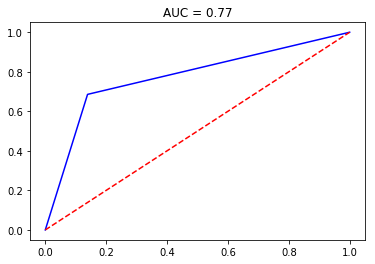

In [31]:
from sklearn.linear_model.logistic import LogisticRegression

model = LogisticRegression().fit(x_train, y_train)
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

metricas_modelos(y_train, y_pred_train)

La matriz de confusión es
[[125  25]
 [ 38  74]]
Precisión: 0.759541984733
Exactitud: 0.747474747475
Exhaustividad: 0.660714285714
F1: 0.701421800948
AUC: 0.747023809524


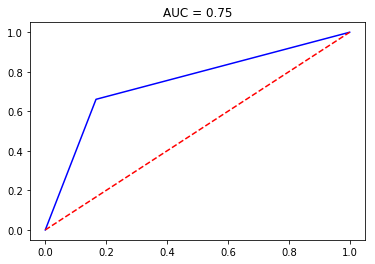

In [32]:
metricas_modelos(y_test, y_pred_test)

Se puede observar que en los dos conjuntos de datos la capacidad predictiva del modelo es muy parecida. Esto hace innecesario eliminar más variables con técnicas como Stepwise.